<div align = 'center' ><h1> Alzheimer CNN Model Training</h1> </div>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, InputLayer, Dropout, BatchNormalization, Rescaling, LeakyReLU, RandomRotation, RandomZoom
import numpy as np
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing import image

<h2> Rescaling Model </h2>

In [ ]:
#Rescaling Model
rescaler = tf.keras.models.Sequential([
    Rescaling(1./255)
])

<h2> Data Augmentator </h2>

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

<h2> Main Model </h2>

In [ ]:
# Define the model
model = tf.keras.models.Sequential()

# Input Layer + Rescaling-
model.add(InputLayer(input_shape=(176, 208, 3), name='Shape-Input'))
model.add(rescaler)

# Data Augmentation
model.add(data_augmentation)

# First Convolutional Block
model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu', name='16-Feature-Convo2D'))
model.add(MaxPooling2D(pool_size=(2, 2), name='Max-Pooling-2D_1'))
model.add(BatchNormalization())

# Second Convolutional Block
model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu', name='32-Feature-Convo2D'))
model.add(MaxPooling2D(pool_size=(2, 2), name='Max-Pooling-2D_2'))
model.add(BatchNormalization())

# Third Convolutional Block
model.add(Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu', name='64-Feature-Convo2D'))
model.add(MaxPooling2D(pool_size=(2, 2), name='Max-Pooling-2D_3'))
model.add(BatchNormalization())

# Flatten & Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5)) 

model.add(Dense(64, kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer (4-class classification)
model.add(Dense(4, activation='softmax')) 

# Compile the Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Print Summary
model.summary()


In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory("D:/python/AlzheimerCNN/data/train" , image_size=(176,208) , batch_size=32, label_mode='categorical')
test_dataset = tf.keras.preprocessing.image_dataset_from_directory("D:/python/AlzheimerCNN/data/test" , image_size=(176,208) , batch_size=32, label_mode='categorical')

<h2> Weight Calculation </h2>

In [ ]:
#Calculating Class Weights manually
class_counts = np.zeros(4)
for _, labels in train_dataset:
    class_counts += np.sum(labels.numpy(), axis=0)

sum_class_counts = np.sum(class_counts)

class_weights = {}
for i, class_count in enumerate(class_counts):
    class_weights[i] = sum_class_counts / (4 * class_count)

class_weights


In [34]:
training = model.fit(train_dataset, epochs=25, class_weight=class_weights, validation_data=test_dataset)

Epoch 1/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - accuracy: 0.5488 - auc_1: 0.8165 - loss: 0.7775 - precision_1: 0.6126 - recall_1: 0.4499 - val_accuracy: 0.5754 - val_auc_1: 0.8469 - val_loss: 0.9890 - val_precision_1: 0.6089 - val_recall_1: 0.5113
Epoch 2/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.5735 - auc_1: 0.8244 - loss: 0.7725 - precision_1: 0.6319 - recall_1: 0.4637 - val_accuracy: 0.5872 - val_auc_1: 0.8427 - val_loss: 0.9655 - val_precision_1: 0.6165 - val_recall_1: 0.4965
Epoch 3/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 30s 185ms/step - accuracy: 0.5795 - auc_1: 0.8336 - loss: 0.7619 - precision_1: 0.6426 - recall_1: 0.4678 - val_accuracy: 0.5856 - val_auc_1: 0.8409 - val_loss: 0.9791 - val_precision_1: 0.6189 - val_recall_1: 0.4965
Epoch 4/25
161/161 ━━━━━━━━━━━━━━━━━━━━ 30s 188ms/step - accuracy: 0.5773 - auc_1: 0.8343 - loss: 0.7391 - precision_1: 0.6453 - recall_1: 0.4710 - val_accuracy: 0.5794 - val_auc_1: 0.8373 - val_loss: 1.1054 - val_precision_1: 0.

In [36]:
def predict_class(path, size):
    img = image.load_img(path, target_size=size)  # Resize to match model input size

    # Convert to array and normalize
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = img_array / 255.0  # Normalize (same as Rescaling(1./255))
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict using the model
    predictions = model.predict(img_array)

    # Get the predicted class index
    return np.argmax(predictions)

In [37]:
model.save("models/AlzheimerCNN_Model.h5")  # Save the trained model

<h2> Training & Validation Loss Curve </h2>

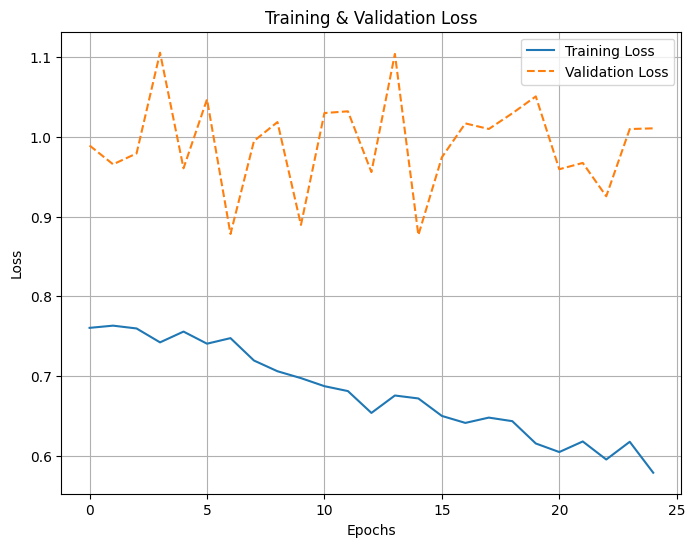

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<h2> Training & Validation Accuracy Curve </h2>

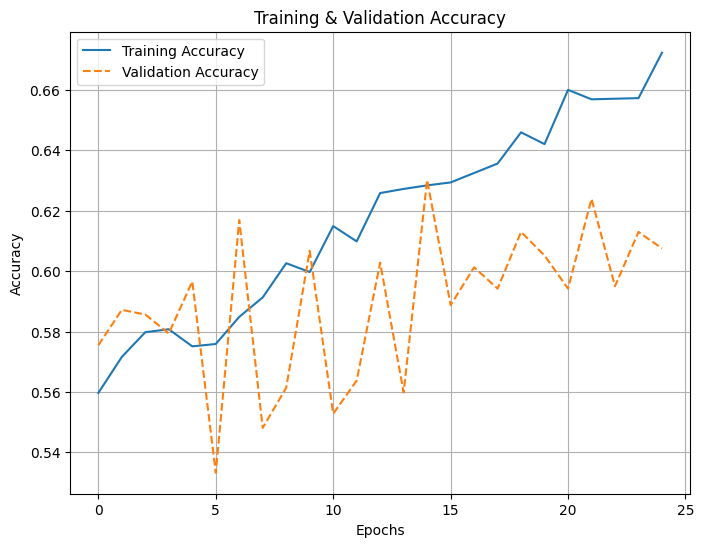

In [39]:
# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(training.history['accuracy'], label='Training Accuracy')
plt.plot(training.history['val_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<h2> Precision-Recall Curve </h2>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━

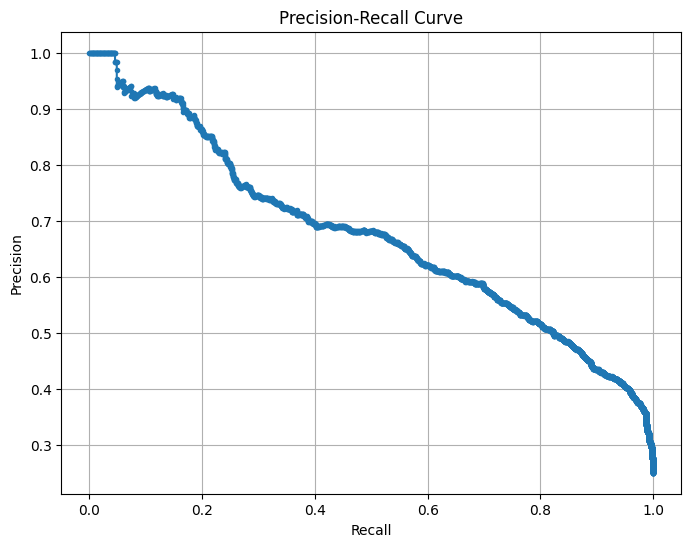

In [40]:
from sklearn.metrics import precision_recall_curve

# Get true labels and predictions
y_true = []
y_scores = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())  # True labels
    y_scores.extend(preds)  # Predicted probabilities

# Convert to NumPy arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Get precision-recall curve
precision, recall, _ = precision_recall_curve(y_true.ravel(), y_scores.ravel())

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

<h2> ROC-AUC Curve </h2>

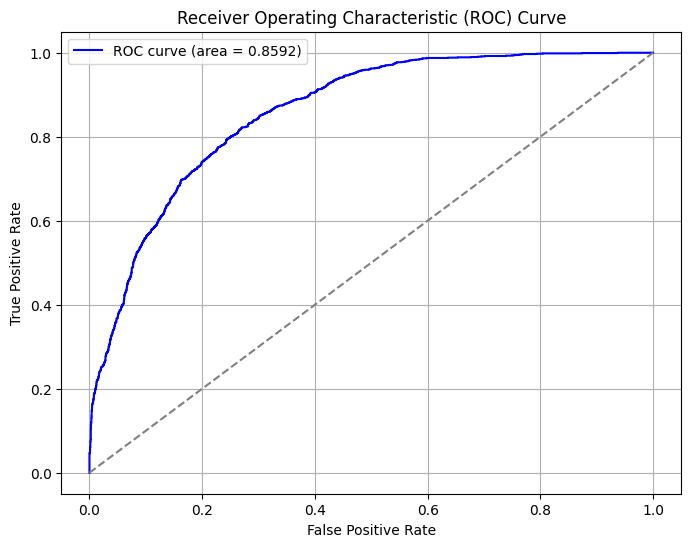

In [41]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()


<h2> Confusion Matrix </h2>

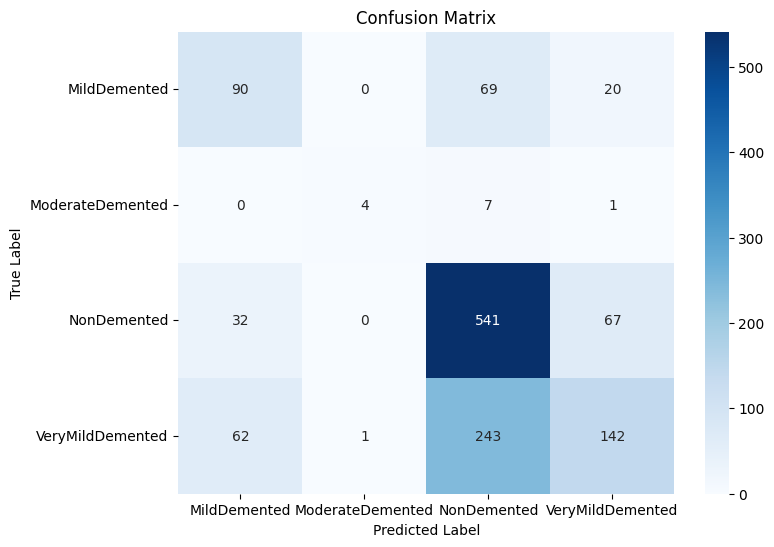

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predicted labels
y_pred = np.argmax(y_scores, axis=1)
y_true_labels = np.argmax(y_true, axis=1)
class_names = train_dataset.class_names

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


<h2> Classification Report </h2>

In [44]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:\n", classification_report(y_true_labels, y_pred, target_names=class_names))

Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.49      0.50      0.50       179
ModerateDemented       0.80      0.33      0.47        12
     NonDemented       0.63      0.85      0.72       640
VeryMildDemented       0.62      0.32      0.42       448

        accuracy                           0.61      1279
       macro avg       0.63      0.50      0.53      1279
    weighted avg       0.61      0.61      0.58      1279

